### EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import warnings
warnings.filterwarnings('ignore')

##### Column names

In [2]:
columns = ['Gender'
,'Symptoms'
,'Alcohol'
,'Hepatitis B Surface Antigen'
,'Hepatitis B e Antigen'
,'Hepatitis B Core Antibody'
,'Hepatitis C Virus Antibody'
,'Cirrhosis'
,'Endemic Countries'
,'Smoking'
,'Diabetes'
,'Obesity'
,'Hemochromatosis'
,'Arterial Hypertension'
,'Chronic Renal Insufficiency'
,'Human Immunodeficiency Virus'
,'Nonalcoholic Steatohepatitis'
,'Esophageal Varices'
,'Splenomegaly'
,'Portal Hypertension'
,'Portal Vein Thrombosis'
,'Liver Metastasis'
,'Radiological Hallmark'
,'Age at diagnosis'
,'Grams of Alcohol per day'
,'Packs of cigarets per year'
,'Performance Status'
,'Encefalopathy degree'
,'Ascites degree'
,'International Normalised Ratio'
,'Alpha-Fetoprotein (ng/mL)'
,'Haemoglobin (g/dL)'
,'Mean Corpuscular Volume (fl)'
,'Leukocytes(G/L)'
,'Platelets (G/L)'
,'Albumin (mg/dL)'
,'Total Bilirubin(mg/dL)'
,'Alanine transaminase (U/L)'
,'Aspartate transaminase (U/L)'
,'Gamma glutamyl transferase (U/L)'
,'Alkaline phosphatase (U/L)'
,'Total Proteins (g/dL)'
,'Creatinine (mg/dL)'
,'Number of Nodules'
,'Major dimension of nodule (cm)'
,'Direct Bilirubin (mg/dL)'
,'Iron (mcg/dL)'
,'Oxygen Saturation (%)'
,'Ferritin (ng/mL)'
,'Class']

columns = list([x.replace(' ', '_').strip() for x in columns])

categorical = ['Gender'
,'Symptoms'
,'Alcohol'
,'Hepatitis B Surface Antigen'
,'Hepatitis B e Antigen'
,'Hepatitis B Core Antibody'
,'Hepatitis C Virus Antibody'
,'Cirrhosis'
,'Endemic Countries'
,'Smoking'
,'Diabetes'
,'Obesity'
,'Hemochromatosis'
,'Arterial Hypertension'
,'Chronic Renal Insufficiency'
,'Human Immunodeficiency Virus'
,'Nonalcoholic Steatohepatitis'
,'Esophageal Varices'
,'Splenomegaly'
,'Portal Hypertension'
,'Portal Vein Thrombosis'
,'Liver Metastasis'
,'Radiological Hallmark'
,'Packs of cigarets per year'
,'Performance Status'
,'Encefalopathy degree'
,'Ascites degree'
,'Class']

categorical = list([x.replace(' ', '_').strip() for x in categorical])

##### Helper functions

In [4]:
### helper functions

## finding missing values
def find_missing_values(data):
    """
    Count all missing values in `data`
    
    """
    # number of rows
    number_rows = data.shape[0]

    # number of missing values
    missing = number_rows - data.count().sort_values()
    missing = pd.DataFrame((missing.index, missing.values))
    missing = missing.T
    missing.columns = ["features", "number of missing"]

    # perentage of missing data
    missing["percentage of missing data"] = missing["number of missing"]*100/number_rows
    
    # use columns as index
    missing = missing.set_index('features')
    
    return missing

## creates dummy variables
def dummies(data, needs_encoding):
    
    for variable in needs_encoding:
        temp = pd.get_dummies(data[variable]).rename(columns=lambda x: variable + '_' + str(x))
        data = pd.concat([data, temp], axis=1)
        data = data.drop([variable], axis=1)
        
    return data


## simple wrapper for sklearn.impute for easy implementation
def modified_imputer(data, strategy, categorical = categorical):
    
    data_numerical = data.drop(categorical, axis=1) # get numerical variable
    data_categorical = data[categorical] # get categorical variable
    
    ## impute all categorical data using mode
    imputer_categorical = SimpleImputer(strategy = 'most_frequent')
    imputer_categorical_fit_transform = imputer_categorical.fit_transform(data_categorical)
    
    ## impute numerical data
    if strategy == 'iterative':
        # impute the values using scikit-learn IterativeImputer Class
        imputer_ = IterativeImputer(max_iter=10, verbose=0)
        imputer_.fit(data_numerical)
        imputer_fit_transform = imputer_.transform(data_numerical)
    else:
        # impute the values using scikit-learn SimpleImputer Class
        imputer_ = SimpleImputer(strategy = strategy)
        imputer_fit_transform = imputer_.fit_transform(data_numerical)
    
    ## merge both imputed numerical and imputed categorical
    imputed_data = pd.concat([pd.DataFrame(imputer_fit_transform, columns = data_numerical.columns), 
                              pd.DataFrame(imputer_categorical_fit_transform, columns = data_categorical.columns)], 
                             axis = 1)
    
    ## arrange columns with origrinal order
    imputed_data = imputed_data[data.columns]
    
    return imputed_data

#### Get Data

In [5]:
## get data
hcc = pd.read_csv('../data/external/hcc-data.txt', header=None, names=columns, na_values='?')

#### What does the data look like?

In [6]:
hcc.head()

,Gender,Symptoms,Alcohol,Hepatitis_B_Surface_Antigen,Hepatitis_B_e_Antigen,Hepatitis_B_Core_Antibody,Hepatitis_C_Virus_Antibody,Cirrhosis,Endemic_Countries,Smoking,...,Alkaline_phosphatase_(U/L),Total_Proteins_(g/dL),Creatinine_(mg/dL),Number_of_Nodules,Major_dimension_of_nodule_(cm),Direct_Bilirubin_(mg/dL),Iron_(mcg/dL),Oxygen_Saturation_(%),Ferritin_(ng/mL),Class
0,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,...,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,...,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
2,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,...,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
4,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1


In [7]:
hcc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender                            165 non-null    int64  
 1   Symptoms                          147 non-null    float64
 2   Alcohol                           165 non-null    int64  
 3   Hepatitis_B_Surface_Antigen       148 non-null    float64
 4   Hepatitis_B_e_Antigen             126 non-null    float64
 5   Hepatitis_B_Core_Antibody         141 non-null    float64
 6   Hepatitis_C_Virus_Antibody        156 non-null    float64
 7   Cirrhosis                         165 non-null    int64  
 8   Endemic_Countries                 126 non-null    float64
 9   Smoking                           124 non-null    float64
 10  Diabetes                          162 non-null    float64
 11  Obesity                           155 non-null    float64
 12  Hemochro

In [8]:
hcc.describe()

,Gender,Symptoms,Alcohol,Hepatitis_B_Surface_Antigen,Hepatitis_B_e_Antigen,Hepatitis_B_Core_Antibody,Hepatitis_C_Virus_Antibody,Cirrhosis,Endemic_Countries,Smoking,...,Alkaline_phosphatase_(U/L),Total_Proteins_(g/dL),Creatinine_(mg/dL),Number_of_Nodules,Major_dimension_of_nodule_(cm),Direct_Bilirubin_(mg/dL),Iron_(mcg/dL),Oxygen_Saturation_(%),Ferritin_(ng/mL),Class
count,165.000000,147.000000,165.000000,148.000000,126.000000,141.000000,156.000000,165.000000,126.000000,124.000000,...,162.000000,154.000000,158.000000,163.000000,145.000000,121.000000,86.000000,85.000000,85.000000,165.000000
mean,0.806061,0.639456,0.739394,0.108108,0.007937,0.269504,0.217949,0.903030,0.079365,0.508065,...,212.211605,8.961039,1.127089,2.736196,6.851172,1.930000,85.598837,37.028941,438.997647,0.618182
std,0.396586,0.481800,0.440302,0.311571,0.089087,0.445284,0.414182,0.296817,0.271387,0.501963,...,167.943548,11.728739,0.955856,1.797901,5.095042,4.210452,55.698995,28.993552,457.114454,0.487311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.280000,3.900000,0.200000,0.000000,1.500000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,108.250000,6.300000,0.700000,1.000000,3.000000,0.370000,40.500000,16.000000,84.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,162.000000,7.050000,0.850000,2.000000,5.000000,0.700000,83.000000,27.000000,295.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,261.500000,7.575000,1.100000,5.000000,9.000000,1.400000,118.000000,56.000000,706.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,980.000000,102.000000,7.600000,5.000000,22.000000,29.300000,224.000000,126.000000,2230.000000,1.000000


##### TO-DO
Some notes

#### Is there missing data?

In [9]:
hcc_missing = find_missing_values(hcc)
hcc_missing

,number of missing,percentage of missing data
features,,
Oxygen_Saturation_(%),80,48.4848
Ferritin_(ng/mL),80,48.4848
Iron_(mcg/dL),79,47.8788
Packs_of_cigarets_per_year,53,32.1212
Esophageal_Varices,52,31.5152
Grams_of_Alcohol_per_day,48,29.0909
Direct_Bilirubin_(mg/dL),44,26.6667
Smoking,41,24.8485
Hepatitis_B_e_Antigen,39,23.6364


#### Visualise missing data with `missingno`

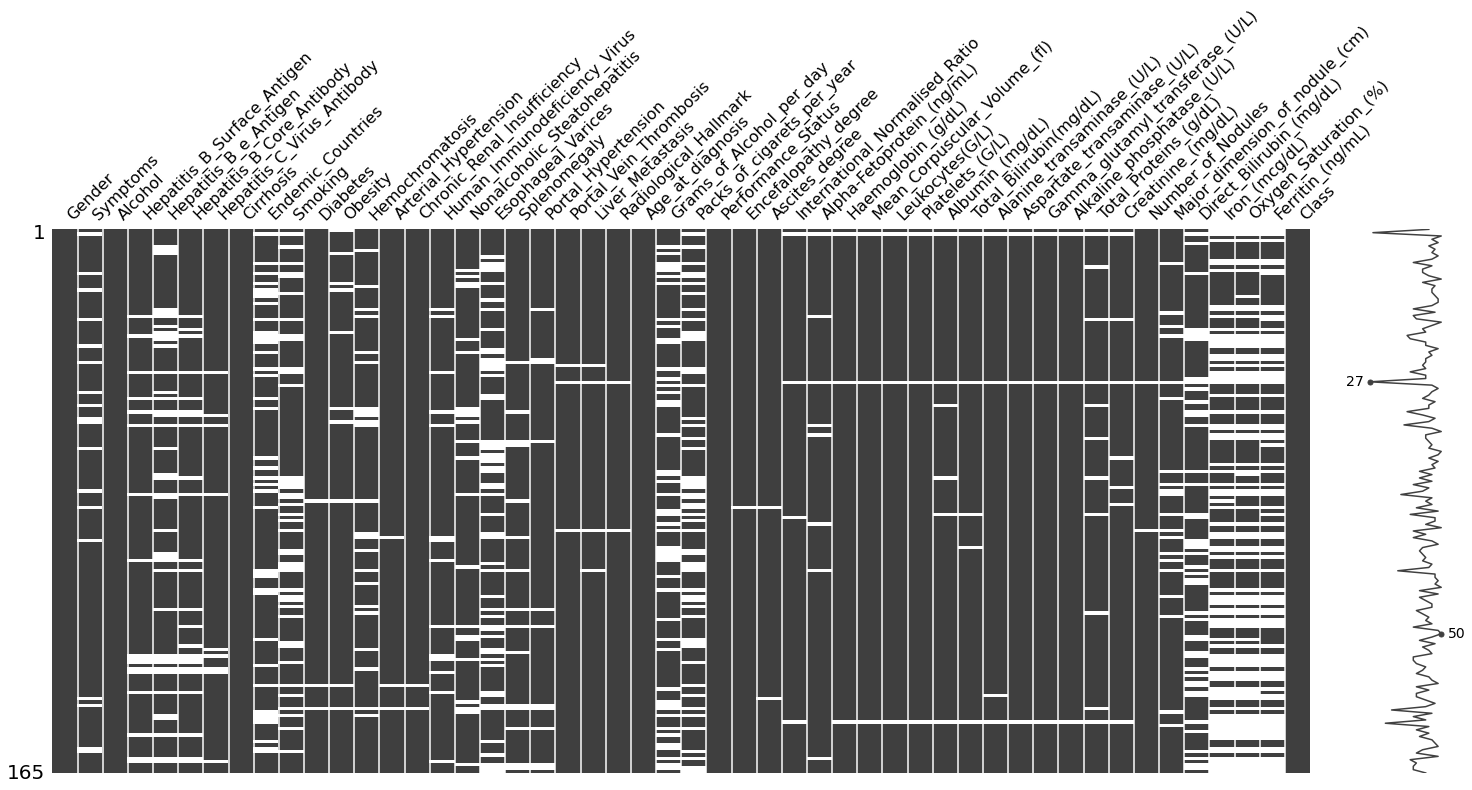

In [10]:
%matplotlib inline
msno.matrix(hcc);

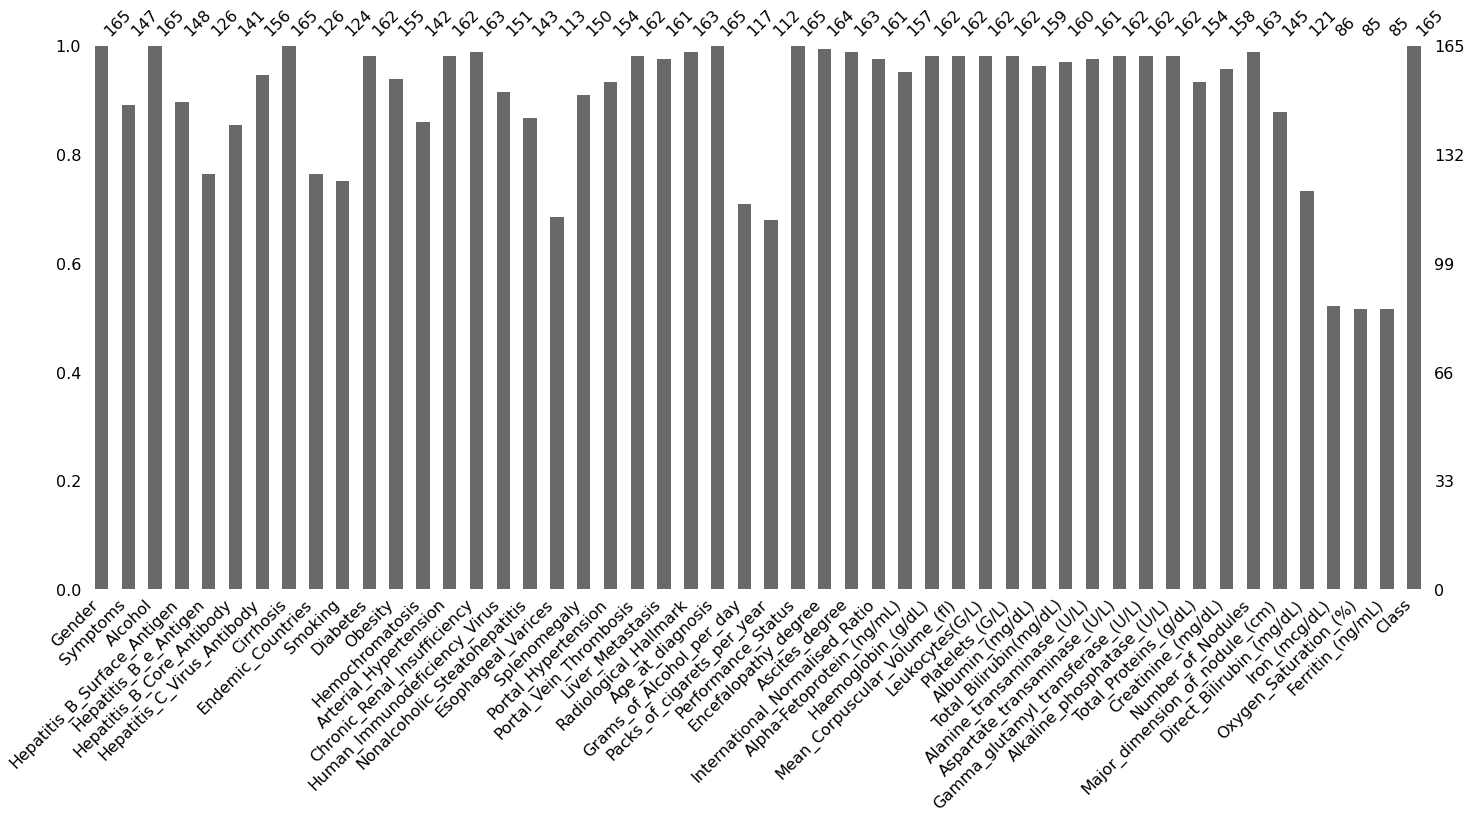

In [11]:
msno.bar(hcc); # a bar chart of the missing values

#### Using SimpleImputer and IterativeImputer to generate 4 datasets

In [12]:
hcc_mean_imputed = modified_imputer(hcc, "mean") # strategy mean on SimpleImputer
hcc_mean_imputed.head()

,Gender,Symptoms,Alcohol,Hepatitis_B_Surface_Antigen,Hepatitis_B_e_Antigen,Hepatitis_B_Core_Antibody,Hepatitis_C_Virus_Antibody,Cirrhosis,Endemic_Countries,Smoking,...,Alkaline_phosphatase_(U/L),Total_Proteins_(g/dL),Creatinine_(mg/dL),Number_of_Nodules,Major_dimension_of_nodule_(cm),Direct_Bilirubin_(mg/dL),Iron_(mcg/dL),Oxygen_Saturation_(%),Ferritin_(ng/mL),Class
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,150.000000,7.100000,0.700000,1.0,3.5,0.50,85.598837,37.028941,438.997647,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,212.211605,8.961039,1.127089,1.0,1.8,1.93,85.598837,37.028941,438.997647,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.000000,7.000000,2.100000,5.0,13.0,0.10,28.000000,6.000000,16.000000,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,174.000000,8.100000,1.110000,2.0,15.7,0.20,85.598837,37.028941,438.997647,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.000000,6.900000,1.800000,1.0,9.0,1.93,59.000000,15.000000,22.000000,1.0


In [13]:
hcc_median_imputed = modified_imputer(hcc, "median") # strategy median on SimpleImputer
hcc_median_imputed.head()

,Gender,Symptoms,Alcohol,Hepatitis_B_Surface_Antigen,Hepatitis_B_e_Antigen,Hepatitis_B_Core_Antibody,Hepatitis_C_Virus_Antibody,Cirrhosis,Endemic_Countries,Smoking,...,Alkaline_phosphatase_(U/L),Total_Proteins_(g/dL),Creatinine_(mg/dL),Number_of_Nodules,Major_dimension_of_nodule_(cm),Direct_Bilirubin_(mg/dL),Iron_(mcg/dL),Oxygen_Saturation_(%),Ferritin_(ng/mL),Class
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,150.0,7.10,0.70,1.0,3.5,0.5,83.0,27.0,295.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,162.0,7.05,0.85,1.0,1.8,0.7,83.0,27.0,295.0,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.0,7.00,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,174.0,8.10,1.11,2.0,15.7,0.2,83.0,27.0,295.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.0,6.90,1.80,1.0,9.0,0.7,59.0,15.0,22.0,1.0


In [14]:
hcc_mode_imputed = modified_imputer(hcc, "most_frequent") # strategy mode on SimpleImputer
hcc_mode_imputed.head()

,Gender,Symptoms,Alcohol,Hepatitis_B_Surface_Antigen,Hepatitis_B_e_Antigen,Hepatitis_B_Core_Antibody,Hepatitis_C_Virus_Antibody,Cirrhosis,Endemic_Countries,Smoking,...,Alkaline_phosphatase_(U/L),Total_Proteins_(g/dL),Creatinine_(mg/dL),Number_of_Nodules,Major_dimension_of_nodule_(cm),Direct_Bilirubin_(mg/dL),Iron_(mcg/dL),Oxygen_Saturation_(%),Ferritin_(ng/mL),Class
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,150.0,7.1,0.70,1.0,3.5,0.5,94.0,25.0,48.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,109.0,7.3,0.70,1.0,1.8,0.3,94.0,25.0,48.0,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,174.0,8.1,1.11,2.0,15.7,0.2,94.0,25.0,48.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.0,6.9,1.80,1.0,9.0,0.3,59.0,15.0,22.0,1.0


In [15]:
hcc_iterative_imputed = modified_imputer(hcc, "iterative") # IterativeImputer
hcc_iterative_imputed.head()

,Gender,Symptoms,Alcohol,Hepatitis_B_Surface_Antigen,Hepatitis_B_e_Antigen,Hepatitis_B_Core_Antibody,Hepatitis_C_Virus_Antibody,Cirrhosis,Endemic_Countries,Smoking,...,Alkaline_phosphatase_(U/L),Total_Proteins_(g/dL),Creatinine_(mg/dL),Number_of_Nodules,Major_dimension_of_nodule_(cm),Direct_Bilirubin_(mg/dL),Iron_(mcg/dL),Oxygen_Saturation_(%),Ferritin_(ng/mL),Class
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,150.000000,7.100000,0.700000,1.0,3.5,0.500000,98.892078,45.321109,313.390830,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,217.367314,8.980714,1.125346,1.0,1.8,1.449091,81.313717,33.150812,444.526474,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.000000,7.000000,2.100000,5.0,13.0,0.100000,28.000000,6.000000,16.000000,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,174.000000,8.100000,1.110000,2.0,15.7,0.200000,79.963385,35.746317,164.355338,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,109.000000,6.900000,1.800000,1.0,9.0,0.181116,59.000000,15.000000,22.000000,1.0


#### Check correlation

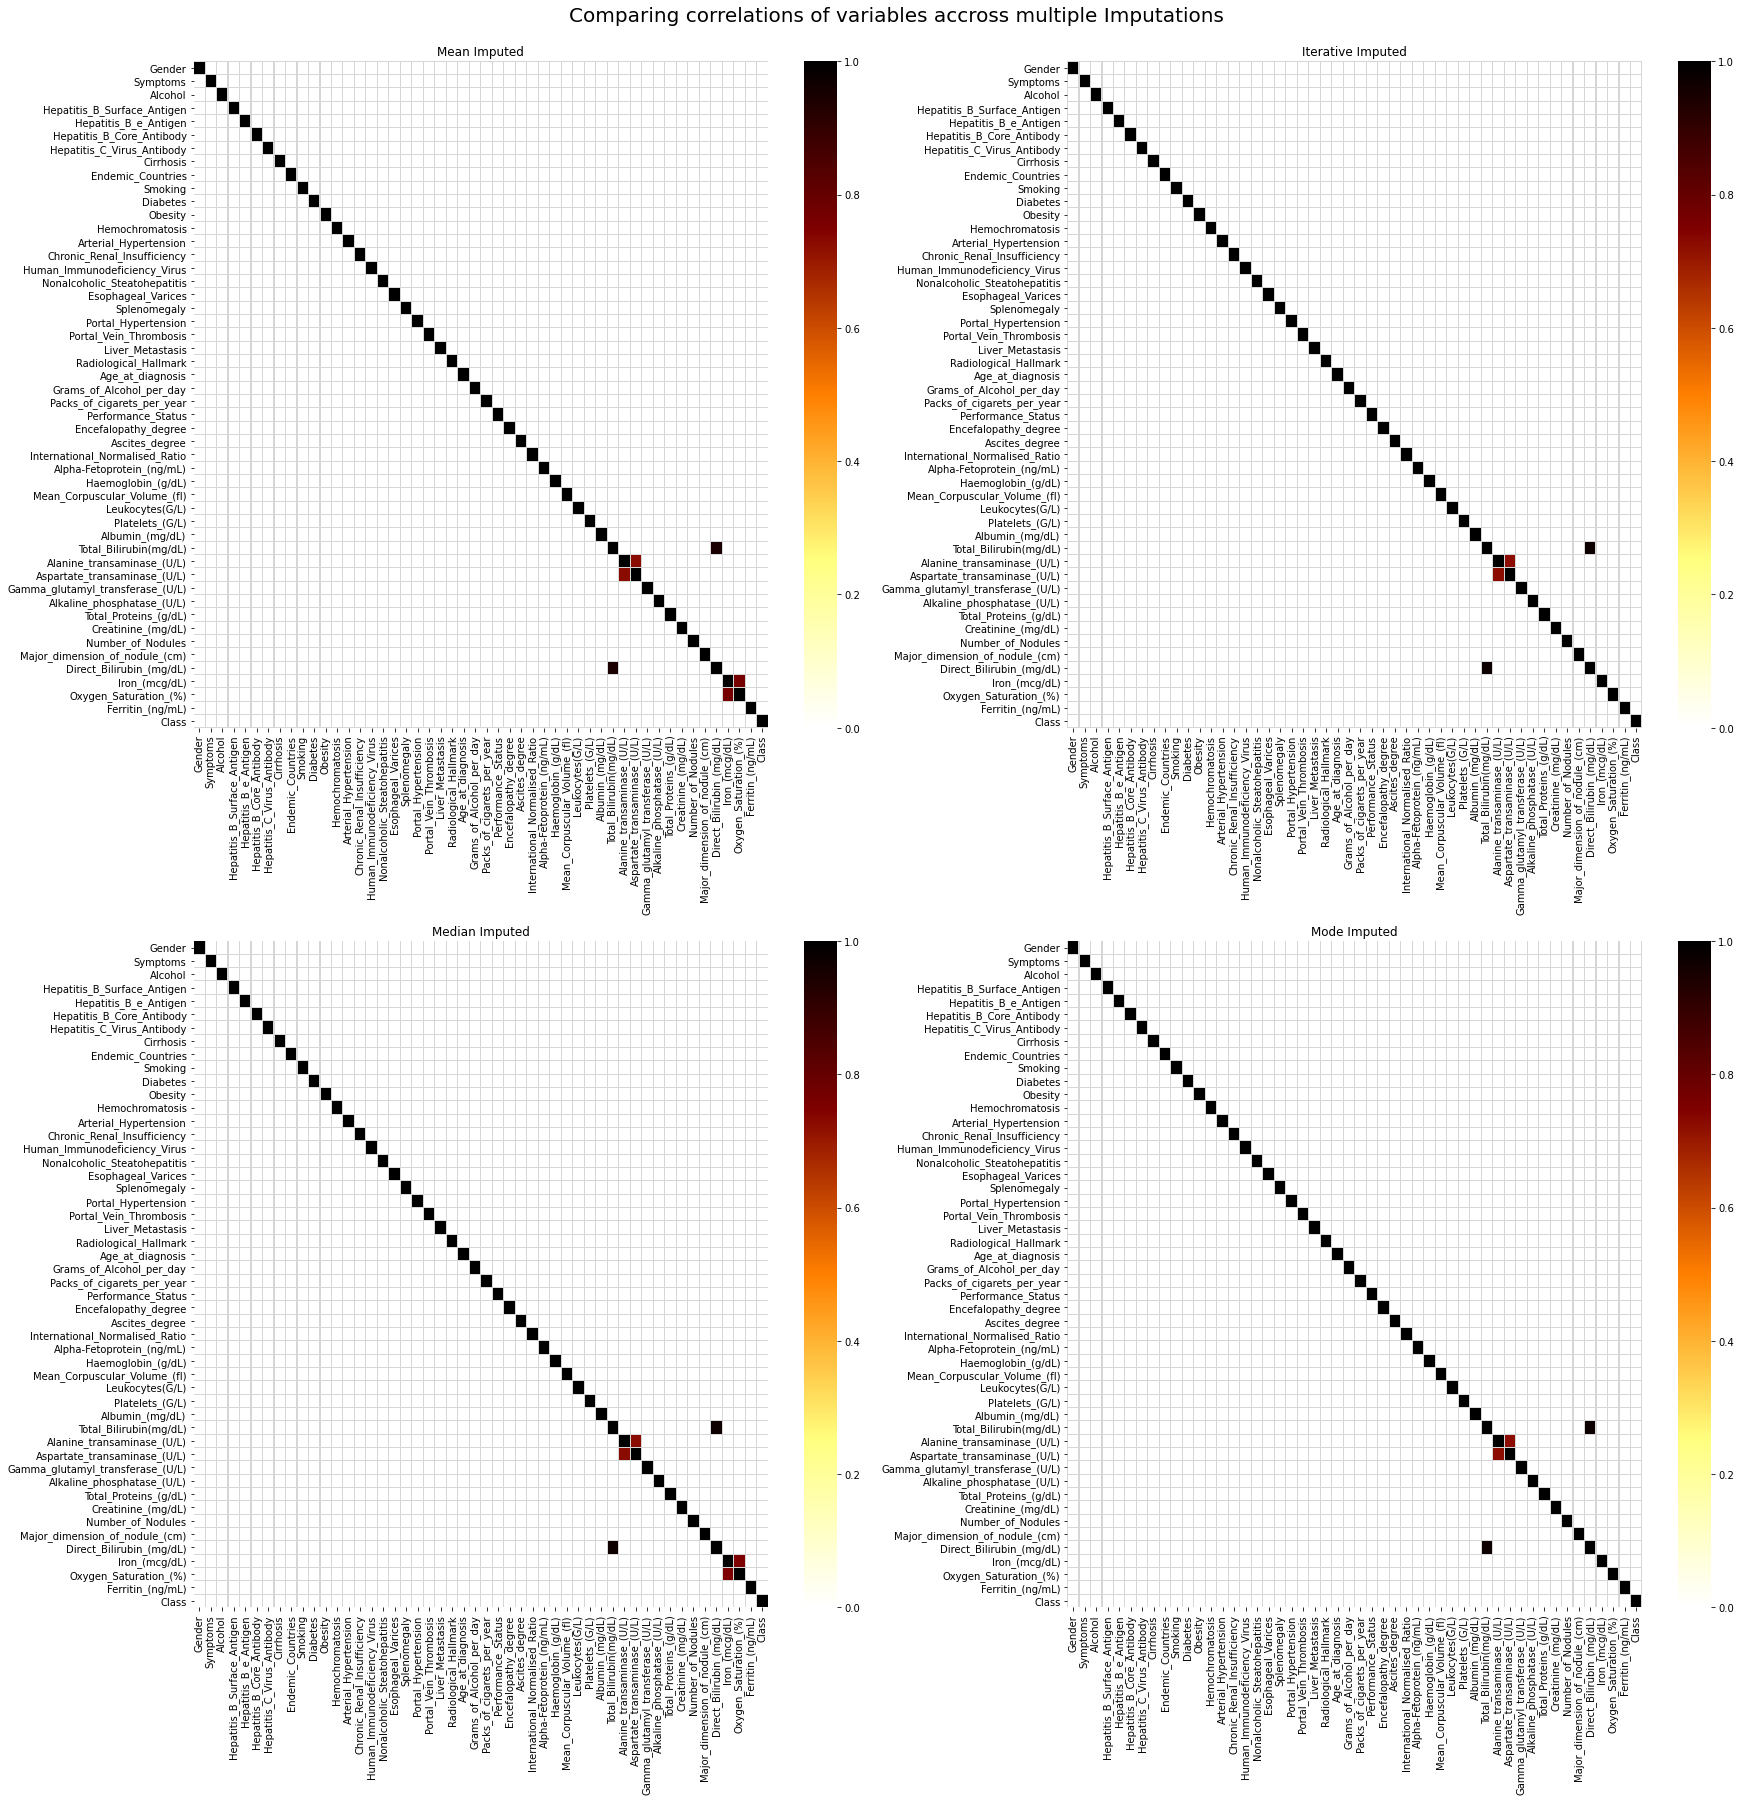

In [16]:
hcc_mean_imputed_corr = hcc_mean_imputed.corr(method='pearson')
hcc_median_imputed_corr = hcc_median_imputed.corr(method='pearson')
hcc_mode_imputed_corr = hcc_mode_imputed.corr(method='pearson')
hcc_iterative_imputed_corr = hcc_mode_imputed.corr(method='pearson')

## set correlation coef limit
limit = 0.70
hcc_mean_imputed_corr[np.abs(hcc_mean_imputed_corr) < limit] = 0
hcc_median_imputed_corr[np.abs(hcc_median_imputed_corr) < limit] = 0
hcc_mode_imputed_corr[np.abs(hcc_mode_imputed_corr) < limit] = 0
hcc_iterative_imputed_corr[np.abs(hcc_iterative_imputed_corr) < limit] = 0


## Plotting
fig, ax = plt.subplots(figsize=(25,25), ncols=2, nrows=2)

plt.suptitle("Comparing correlations of variables accross multiple Imputations", y = 0.999, fontsize=20)

ax[0][0].set_title("Mean Imputed")
ax[1][0].set_title("Median Imputed")
ax[1][1].set_title("Mode Imputed")
ax[0][1].set_title("Iterative Imputed")

sns.heatmap(hcc_mean_imputed_corr,      cmap="afmhot_r", linewidths=0.1, linecolor='#d6d6d6', xticklabels=True, ax=ax[0][0])
sns.heatmap(hcc_median_imputed_corr,    cmap="afmhot_r", linewidths=0.1, linecolor='#d6d6d6', xticklabels=True, ax=ax[1][0])
sns.heatmap(hcc_mode_imputed_corr,      cmap="afmhot_r", linewidths=0.1, linecolor='#d6d6d6', xticklabels=True, ax=ax[1][1])
sns.heatmap(hcc_iterative_imputed_corr, cmap="afmhot_r", linewidths=0.1, linecolor='#d6d6d6', xticklabels=True, ax=ax[0][1])

plt.tight_layout() # minimize overlaps

plt.show()

#### Are there correlations that would allow you to remove columns?

From the heatmaps above, we can infer that;   
`Iron_(mcg/dL)` & `Oxygen_Saturation_(%)` have a strong correlation for `mean` & `median` imputed datasets  
`Alanine_transaminase_(U/L)` & `Aspartate_transaminase_(U/L)` have a strong correlation for all four datasets  
`Direct_Bilirubin_(mg/dL)` & `Total_Bilirubin(mg/dL)` also have a strong correlation for all four datasets

In [17]:
## drop one pair of variables with strong correlation

hcc_mean_imputed = hcc_mean_imputed.drop(['Iron_(mcg/dL)', 'Alanine_transaminase_(U/L)', 'Direct_Bilirubin_(mg/dL)'], axis = 1)
hcc_median_imputed = hcc_median_imputed.drop(['Iron_(mcg/dL)', 'Alanine_transaminase_(U/L)', 'Direct_Bilirubin_(mg/dL)'], axis = 1)
hcc_mode_imputed = hcc_mode_imputed.drop(['Alanine_transaminase_(U/L)', 'Direct_Bilirubin_(mg/dL)'], axis = 1)
hcc_iterative_imputed = hcc_iterative_imputed.drop(['Alanine_transaminase_(U/L)', 'Direct_Bilirubin_(mg/dL)'], axis = 1)

#### Is there any data that needs to be encoded?

We will encode the following ordinal variables; `Performance_Status`, `Encefalopathy_degree`, `Ascites_degree`

In [18]:
needs_encoding = ["Performance_Status", "Encefalopathy_degree", "Ascites_degree"]


hcc_mean_imputed = dummies(hcc_mean_imputed, needs_encoding)
hcc_median_imputed = dummies(hcc_median_imputed, needs_encoding)
hcc_mode_imputed = dummies(hcc_mode_imputed, needs_encoding)
hcc_iterative_imputed = dummies(hcc_iterative_imputed, needs_encoding)

#### What proportion of the population dies?

In [19]:
hcc['Class'].value_counts(normalize=True)

1    0.618182
0    0.381818
Name: Class, dtype: float64

About $38\%$ of the population dies

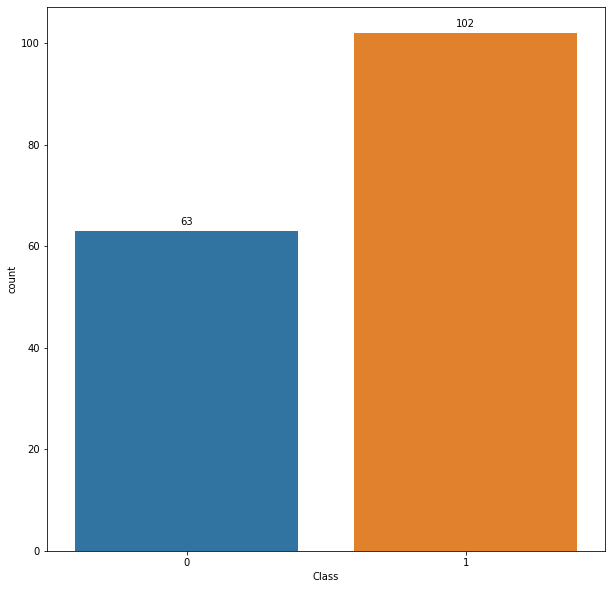

In [20]:
plt.figure(figsize=(10, 10))
_ = sns.countplot('Class', data=hcc)
for p in _.patches:
    _.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### Export datasets for modelling

In [21]:
hcc_mean_imputed.to_csv('../data/processed/hcc_mean_imputed.csv', index=False)
hcc_median_imputed.to_csv('../data/processed/hcc_median_imputed.csv', index=False)
hcc_mode_imputed.to_csv('../data/processed/hcc_mode_imputed.csv', index=False)
hcc_iterative_imputed.to_csv('../data/processed/hcc_iterative_imputed.csv', index=False)